In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Add fixed params to dict

main_panels = 20
params = {}
params['c'] = 0.067
params['alpha_r'] = 0
params['c_d_max'] = 1
params['Lambda'] = np.deg2rad(0)
params['alpha_c'] = np.deg2rad(0)
params['p'] = 1
params['sigma'] = 0

In [3]:
# create lift distribution
def create_lift_dist_from_file(filename,span,sigma,main_panels):
    s_w = span*(1-sigma)
    delta = s_w / main_panels
    y_panel = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()/df['span']*span*100
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def create_const_lift_dist(main_panels):   
    return [np.pi*2]*main_panels

In [4]:
# create configs
configs = []
locked_params = {}
locked_params['m_w'] = 0.884
locked_params['I_xx_w'] = 0.03978611
locked_params['y_w'] = 0.00047
locked_params['z_w'] = -0.00238
locked_params['s'] = 1
locked_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_100.csv',
                                                locked_params['s'],params['sigma'],main_panels)
configs.append(({'Mode':'Locked','LiftDist':'Roll60'},locked_params))

locked_params = {}
locked_params['m_w'] = 0.884
locked_params['I_xx_w'] = 0.03978611
locked_params['y_w'] = 0.00047
locked_params['z_w'] = -0.00238
locked_params['s'] = 1
locked_params['a'] = create_const_lift_dist(main_panels)
configs.append(({'Mode':'Locked','LiftDist':'Const'},locked_params))

removed_params = {}
removed_params['m_w'] = 0.735
removed_params['I_xx_w'] = 0.014820479
removed_params['y_w'] = 0.0020145
removed_params['z_w'] = -0.002775
removed_params['s'] = 0.728
removed_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_73.csv',
                                                 removed_params['s'],params['sigma'],main_panels)
configs.append(({'Mode':'Removed','LiftDist':'Roll60'},removed_params))

removed_params = {}
removed_params['m_w'] = 0.735
removed_params['I_xx_w'] = 0.014820479
removed_params['y_w'] = 0.0020145
removed_params['z_w'] = -0.002775
removed_params['s'] = 0.728
removed_params['a'] = create_const_lift_dist(main_panels)
configs.append(({'Mode':'Removed','LiftDist':'Const'},removed_params))

In [5]:
# create Jobs
attitudes=[]
vs = [15,20,25,30]
T = [0.06,0.12]
for time_const in T: 
    for v in vs:
        aas = [7,14,21]
        offset = [-0.08,-0.05,0.05]
        for i,tm in enumerate([1.05,1.48,1.75]):
            beta = (tm)*8.4e-4*v**2+offset[i]
            attitudes.append(({"AileronAngle":aas[i],},{"V":v,"beta":beta,"T":time_const}))
jobs=[({**config,**att},{**params,**config_params,**att_params}) for config,config_params in configs for att,att_params in attitudes]

In [6]:
jobs[5][1]['beta']

11.459155902616466
30.0


0        0.00
1        0.01
2        0.02
3        0.03
4        0.04
        ...  
2996    29.96
2997    29.97
2998    29.98
2999    29.99
3000    30.00
Name: t, Length: 3001, dtype: float64

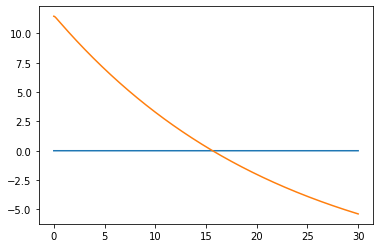

In [7]:
job = jobs[10]
job[1]['beta'] = 0
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
#GenRunData('tempModel.py',3,[0]*p.qs*2,10,{**params,**jobs[0]},names,{'Mode':'Free'},100)[100]
# data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],10,jobs[0][1],main_panels,names[:2],{**jobs[0][0],**{n:0 for n in names[2:]}},100)

def stop_event(t,y):
    if t<=10:
        return 1
    else:
        return np.deg2rad(360*3+5) - abs(y[0])
stop_event.terminal = True


data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0.2,0],30,params=job[1],
                                     panels=main_panels,
                                     calc_coast=False,
                                     xNames=names,
                                     additional_cols={**job[0]},
                                     sample_freq=100,
                                    events = [stop_event])


df = pd.DataFrame(data)
plt.plot(df['t'],df['torque'])
plt.plot(df['t'],np.rad2deg(df['Roll']))
# print(np.rad2deg(df[df['t']>4]['Roll Rate'].mean()))
# {**jobs[0][0],**jobs[0][1]}
print(np.rad2deg(df['Roll'].max()))
print(df['t'].max())
df['t']

# plt.plot(np.rad2deg(df['Roll Rate']),np.gradient(np.rad2deg(df['Roll Rate'])))

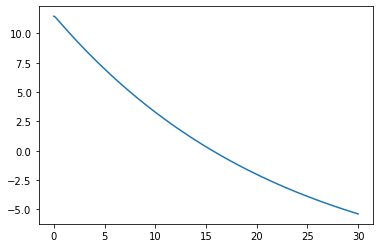

In [8]:
plt.plot(df['t'],np.rad2deg(df['Roll']))


In [9]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']

def stop_event(t,y):
    if t<=10:
        return 1
    else:
        return np.deg2rad(360*3+5) - abs(y[0])
stop_event.terminal = True


res=[]
for job in jobs:
    res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('RollRigModel-Fixed.py',1,[0]*2,60,job[1],
                                                                       main_panels,False,names[:2],
                                                                       {**job[0],**{n:0 for n in names[2:]}},500,[stop_event])))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 11.8 s, sys: 2.49 s, total: 14.3 s
Wall time: 17.6 s


In [10]:
df['Roll Rate [Deg]']=np.rad2deg(df['Roll Rate'])
df[df['t']>4].groupby(['Mode','V','AileronAngle'])['Roll Rate [Deg]'].mean()

Mode     V   AileronAngle
Locked   15  7               -24.345171
             14              -47.801902
             21              -78.472046
         20  7               -42.559250
             14              -69.313474
             21              -99.051080
         25  7               -58.584061
             14              -89.540589
             21             -123.489725
         30  7               -73.563592
             14              -29.047988
             21             -146.750762
Removed  15  7               -65.306303
             14             -133.618721
             21             -223.627978
         20  7              -117.056973
             14             -197.380215
             21             -281.406984
         25  7              -165.409855
             14             -255.818603
             21             -341.601818
         30  7              -209.797892
             14             -313.972466
             21             -403.296309
Name: Roll Rat

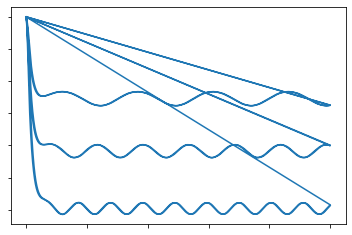

In [11]:
test = df.copy()
test = test[(test['V']==20) & (test['Mode']=='Removed') & (test['LiftDist']=='Roll60')]

plt.plot(test['t'],test['Roll Rate'])

In [12]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparisonV2/FixedData.csv', index = False)

In [13]:
np.unique(df['T'])

array([0.06, 0.12])